<a href="https://colab.research.google.com/github/100485446-UC3M/Segunda_Practica_Machine_Learning_Grupo16/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicciones Práctica 1
## Esteban Gómez Buitrago 100485446
## Nicolás Alejandro Cuesta García 100495966
## Grupo 16

# Visualización de datos con PCA (Principal Component Analysis)
El primer paso es determinar cuál método de escalado va a ser el mejor para el
problema. Para lograr esto, utilizaremos PCA.

Para emplear PCA primero es necesario importar las librerías pertinentes y declarar una semilla de replicación.

In [7]:
#Las librerías necesarias son importadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.datasets import load_iris


np.random.seed(100495966)

Ahora vamos a realizar el proceso de PCA para transformar los datos a 2D y poder visualizarlos correctamente. Hacer esto nos va a lleavr a reducir la dimensionalidad de nuestro problema y también mediante la visualización nos va a permitir elegir cuál es el mejor scaler para este escenario.


Creando Pipelines
 -> Pipeline 'MinMaxScaler' completada.

    -> Varianza Explicada: [0.78903362 0.1290949 ]
    -> Varianza Acumulada: [0.78903362 0.91812852]

 -> Pipeline 'RobustScaler' completada.

    -> Varianza Explicada: [0.66945748 0.19962637]
    -> Varianza Acumulada: [0.66945748 0.86908385]

 -> Pipeline 'StandardScaler' completada.

    -> Varianza Explicada: [0.71874303 0.17108184]
    -> Varianza Acumulada: [0.71874303 0.88982486]



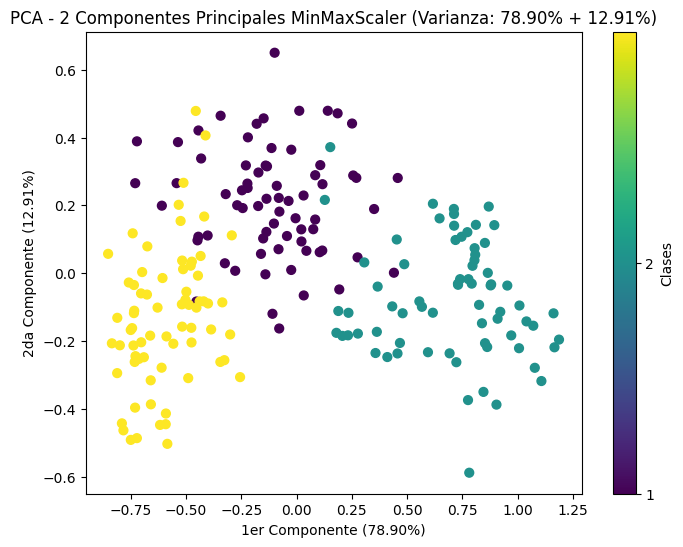

<Figure size 640x480 with 0 Axes>

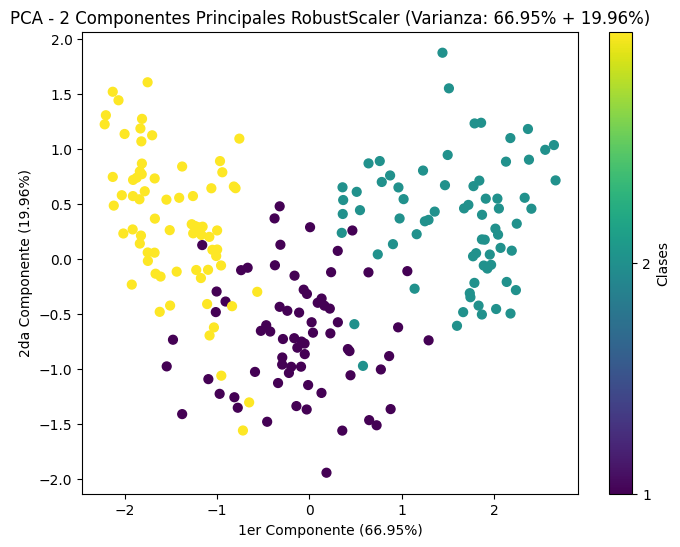

<Figure size 640x480 with 0 Axes>

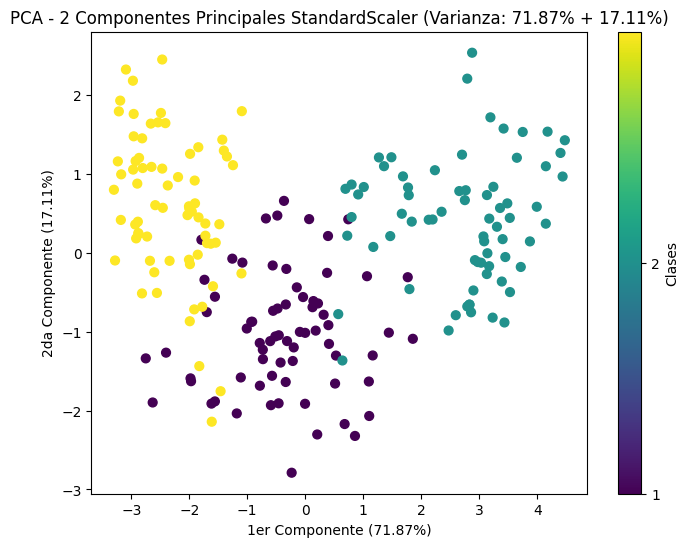

<Figure size 640x480 with 0 Axes>

In [35]:
# Cargar datos
data = pd.read_csv('semillas.csv')
X = data.drop(columns=["clase"])
Y = data["clase"]
#Para chequear que sea el set de datos correcto
#print(data.head())

# Declaramos los Scalers
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

#Definimos que son dos componentes
pca = PCA(n_components=2)

#Creamos las pipelines
X_Reduced = {} # Diccionario para guardar los datos transformados
explained_variance = {}
cumulative_variance = {}

print("\nCreando Pipelines")
for name, scaler in scalers.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', pca)
    ])

    # Ajustar y transformar los datos de características X
    X_Reduced[name] = pipeline.fit_transform(X)
    pca_fitted = pipeline.named_steps['pca']
    # Varianza explicada y acumulada
    explained_variance[name] = pca_fitted.explained_variance_ratio_
    cumulative_variance [name]= np.cumsum(explained_variance[name])
    print(f" -> Pipeline '{name}' completada.\n")
    print(f"    -> Varianza Explicada: {explained_variance[name]}")
    print(f"    -> Varianza Acumulada: {cumulative_variance[name]}\n")

plot_index = 0
for name, data_transformed in X_Reduced.items():
    # Visualizar
    plt.figure(figsize=(8, 6))
    plt.scatter(data_transformed[:, 0], data_transformed[:, 1], c=Y, s=40, cmap='viridis')
    plt.title('PCA - 2 Componentes Principales {} (Varianza: {:.2%} + {:.2%})'.format(name, explained_variance[name][0], explained_variance[name][1]))
    plt.xlabel('1er Componente ({:.2%})'.format(explained_variance[name][0]))
    plt.ylabel('2da Componente ({:.2%})'.format(explained_variance[name][1]))
    plt.colorbar(ticks=range(3), label='Clases')
    plt.show()

    plt.tight_layout()
    plt.show()


En base a los gráficos obtenidos se puede relaizar un análisis visual para determinar la mejor forma de escalado. Pese a que la separación de los grupos
(clusters) en los tre gráficos es similar, en nuestra opinión los clusters más compactos se encuentran en el gráfico de MinMaxScaler. Para confirmar que este es el mejor escalado analizamos los valores de varianza explicada. En estos valores el mayor resultado en la varianza, por más de 7%, fue dado por esta misma forma de escalado. En conclusión, se determinó que los mejores resultados fueron dados por el MinMax Scaler.

# Clustering
Ahora se van a aplicar tres formas de clustering y se analizarán los resultados obtenidos: K-Means, Hierarchical Clustering/Dendrogramas y DBSCAN.



## K-Means
Se va a comenzar con el método de K-Means. Aquí vamos a determinar el número de clusters con ayuda del método "codo" y "silueta".


--- Aplicando K-Means ---

Resultados para los datos escalados con 'MinMaxScaler':


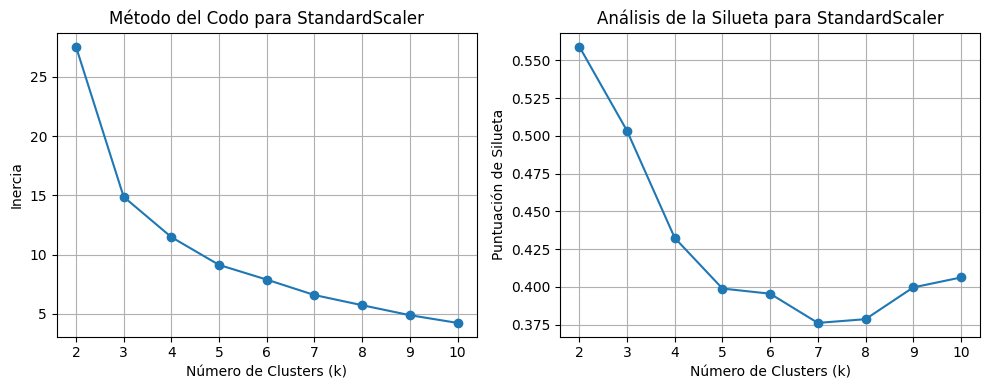


Puntuaciones de codo:
  Número de Clusters: 2, Puntuación: 27.5488
  Número de Clusters: 3, Puntuación: 14.8774
  Número de Clusters: 4, Puntuación: 11.4802
  Número de Clusters: 5, Puntuación: 9.1346
  Número de Clusters: 6, Puntuación: 7.8959
  Número de Clusters: 7, Puntuación: 6.5948
  Número de Clusters: 8, Puntuación: 5.7364
  Número de Clusters: 9, Puntuación: 4.8953
  Número de Clusters: 10, Puntuación: 4.2434

Puntuaciones de Silueta:
  Número de Clusters: 2, Puntuación: 0.5592
  Número de Clusters: 3, Puntuación: 0.5034
  Número de Clusters: 4, Puntuación: 0.4324
  Número de Clusters: 5, Puntuación: 0.3989
  Número de Clusters: 6, Puntuación: 0.3955
  Número de Clusters: 7, Puntuación: 0.3761
  Número de Clusters: 8, Puntuación: 0.3786
  Número de Clusters: 9, Puntuación: 0.3996
  Número de Clusters: 10, Puntuación: 0.4062


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("\n--- Aplicando K-Means ---")

n_clusters_range = range(2, 11) # Rango de número de clusters a probar

for name, X_reduced in X_Reduced.items():
  if name == 'MinMaxScaler':
    X_Final = X_reduced
    print(f"\nResultados para los datos escalados con '{name}':")

inertia_values = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=100495966, n_init=10) # n_init para evitar problemas de convergencia

    # Fit_predict para ambos métodos, método más rápido
    cluster_labels = kmeans.fit_predict(X_Final)

    # Para el método Codo
    inertia_values.append(kmeans.inertia_)

    #Para el método silueta
    silhouette_avg = silhouette_score(X_Final, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Método del codo
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(n_clusters_range, inertia_values, marker='o')
plt.title(f'Método del Codo para {name}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(n_clusters_range)
plt.grid(True)

# Método de la silueta
plt.subplot(1, 2, 2)
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.title(f'Análisis de la Silueta para {name}')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntuación de Silueta')
plt.xticks(n_clusters_range)
plt.grid(True)

plt.tight_layout()
plt.show()

# Imprimir las puntuaciones de codo para facilitar la comparación
print("\nPuntuaciones de codo:")
for i, score in enumerate(inertia_values):
    print(f"  Número de Clusters: {n_clusters_range[i]}, Puntuación: {score:.4f}")

# Imprimir las puntuaciones de silueta para facilitar la comparación
print("\nPuntuaciones de Silueta:")
for i, score in enumerate(silhouette_scores):
    print(f"  Número de Clusters: {n_clusters_range[i]}, Puntuación: {score:.4f}")

AL analizar la gráfica del método "codo", como es de esperarse, la inercia tiende a disminuir a medida que aumentamos el número de clusters. El codo es el punto de la gráfica en el cual la disminución de la inercia comienza a ser más lento, se considera un buen número de clusters el correspondiente a la ubicación del "codo", ya que se considera un punto de equilibrio entre minimizar inercia y no tener exceso de clusters. En este caso, y bajo nuestra opinión, el "codo" se encuentra entre 3 y 4 clusters.

Para analizar con el método silueta se debe analizar la relación entre la putnuación y el número de clusters. La puntuación mide qué tan bien cada muestra se ajusta a su cluster, el número de cluster que maximiza la puntuación se suele considerar la mejor cantidad. En este caso, la puntuación la tuvo cuando se utilizaron 2 clusters.

Utilizando estos dos métodos y promediando los resultados podemos concluir que utilizar 3 clusters es la mejor opción.

Ahora vamos a utilizar un gráfico para ver los clusters:


--- Visualización de Clusters K-Means (MinMaxScaler) ---


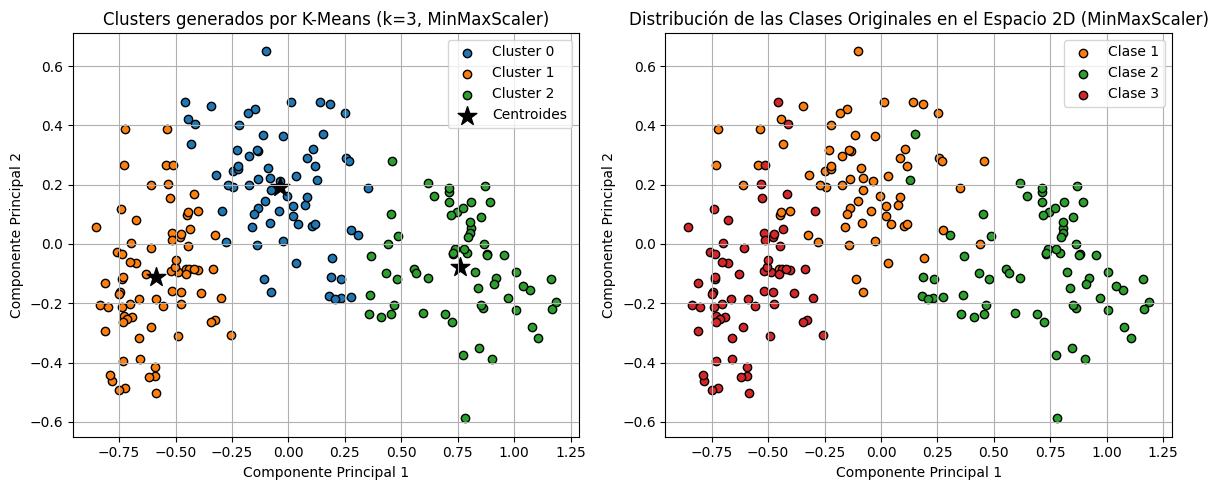

In [33]:
print("\n--- Visualización de Clusters K-Means (MinMaxScaler) ---")

n_clusters_optimal = 3

# Entrenamos K-Means con el número óptimo de clusters en los datos escalados con MinMaxScaler
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=100495966, n_init=10)
cluster_labels_optimal = kmeans_optimal.fit_predict(X_Final)

# Representación gráfica: clusters generados

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Clusters generados por K-means
for i in np.unique(cluster_labels_optimal):
    ax[0].scatter(
        x = X_Final[cluster_labels_optimal == i, 0],
        y = X_Final[cluster_labels_optimal == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

# Centroides de los clusters
ax[0].scatter(
    x = kmeans_optimal.cluster_centers_[:, 0],
    y = kmeans_optimal.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label = 'Centroides'
)

ax[0].set_title(f'Clusters generados por K-Means (k={n_clusters_optimal}, MinMaxScaler)')
ax[0].set_xlabel('Componente Principal 1')
ax[0].set_ylabel('Componente Principal 2')
ax[0].legend()
ax[0].grid(True)

for i in np.unique(Y):
    ax[1].scatter(
        x = X_Final[Y == i, 0],
        y = X_Final[Y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker = 'o',
        edgecolor = 'black',
        label= f"Clase {i}"
    )
ax[1].set_title('Distribución de las Clases Originales en el Espacio 2D (MinMaxScaler)')
ax[1].set_xlabel('Componente Principal 1')
ax[1].set_ylabel('Componente Principal 2')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()